<h2>General Definitions</h2>

In [1]:
#Packages
import numpy as np
import matplotlib.pyplot as plt
import math
import time

#Static variables
#Length of string to be evolved
STRING_LENGTH = 40
#Possible Characters
ALPHABET = ["1","0"]
#Maximum number of generations without improvement
MAX_GEN = 10
#Maximum population size
MAX_POPULATION = 1280
#Initial Pop:
INITIAL_POPULATION = 10
#Smallest difference in population size to explore
MIN_RES = 10
#Number of runs for reliable results
NUM_RUNS = 20
#Threshold for number of runs out of NUM_RUNS that need to be successfull
THRESH_NUM = 19
#Uniform crossover probability of inheriting from parent 1, where 1 denotes 100%
UNICROSS = 0.5
#Deceptive Trap Function Mapping
DECEPTIVE = {
    4:4,3:0,2:1,1:2,0:3
}
#Non-Deceptive Trap Function Dict
NON_DECEPTIVE = {
    4:4,3:0,2:0.5,1:1,0:1.5
}
#Block size for trap functions
BLOCK_SIZE = 4


In [2]:
#Crossover Functions

'''
Input: parent1, parent2 two strings of equal length
iterate bitwise over parent string to create child1 and child2. 
For child1 for each bit choose randomly whether to inherit from parent1 or parent2, make opposite choice for child2
'''

def uniformCrossover(parent1,parent2):
    assert(len(parent1)==len(parent2))
    r,c1,c2 = np.random.random_sample((len(parent1),)),"",""
    for i in range(0,len(parent1)):
        if(r[i]>UNICROSS):
            c1+=(parent1[i])
            c2+=(parent2[i])
        else:
            c1+=(parent2[i])
            c2+=(parent1[i])        
    return(c1,c2)

'''
Input: parent1, parent2 two strings of equal length
Randomly choose two indexes, child1 receives information between theese indices from parent2, information outside of theese indices from parent1. Flip for child2

'''
def twoPointCross(parent1,parent2):
    assert(len(parent1)==len(parent2))
    i1 = np.random.randint(len(parent1))
    i2 = np.random.randint(i1,len(parent1))
    c1_1=parent1[0:i1]
    c2_1=parent2[0:i1]
    c1_2=parent2[i1:i2]
    c2_2=parent1[i1:i2]
    c1_3=parent1[i2::]
    c2_3=parent2[i2::]
    c1=c1_1+c1_2+c1_3
    c2=c2_1+c2_2+c2_3
    return c1,c2
        
#Some basic tests
print(uniformCrossover("AAAAAAAAAAAA","BBBBBBBBBBBB"))
print(uniformCrossover("AAAAAAAGGGGGG","BBBBBBBCCCCCC"))
#print(uniformCrossover("AAAAAAAGGGG","BBBBBBOOOOOO")) # -correctly throws error due to missmatched link
print(twoPointCross("AAAAAAAAAAAA","BBBBBBBBBBBB"))
print(twoPointCross("AAAAAAAGGGGGG","BBBBBBBCCCCCC"))
#print(twoPointCross("AAAAAAAGGGG","BBBBBBOOOOOO")) #-correctly throws error due to missmatched link


('BBABAAABABAA', 'AABABBBABABB')
('ABAABBACCGGGC', 'BABBAABGGCCCG')
('AABBBBBAAAAA', 'BBAAAAABBBBB')
('AAAABBBCCCCCG', 'BBBBAAAGGGGGC')


In [3]:
#Fitness Functions

def counting_ones(sequ,mapping=NON_DECEPTIVE): #TODO what is the mapping doing?
    return sequ.count("1")
    

'''
Given a sequence sequ, and a mapping (NON_DECEPTIVE or DECEPTIVE) calculate the fittness of the sequence
'''
def tightlyLinkedTrapFunction(sequ,mapping=NON_DECEPTIVE):
    res = 0
    for i in range(0,int(len(sequ)/BLOCK_SIZE)):
        si = i*BLOCK_SIZE
        ei = si+BLOCK_SIZE
        block = sequ[si:ei]
        block_fittness = mapping[counting_ones(block)]
        #print(block,block_fittness,res)
        res+=block_fittness
    return res

def looslyLinkedTrapFunction(sequ,mapping=NON_DECEPTIVE):
    n_blocks = int(len(sequ)/BLOCK_SIZE)
    res = 0
    for i in range(0,n_blocks):
        block = ""
        for j in range(0,BLOCK_SIZE):
     #       print(i+n_blocks*j)
            block+=sequ[i+n_blocks*j]
        #print(block)
        block_fittness = mapping[counting_ones(block)]
        res+=block_fittness
    return res
        

#Some tests
assert(counting_ones("1111000011110000")==8)
assert(counting_ones("0000000000000000")==0)
assert(counting_ones("0000000000000111")==3)
assert(counting_ones("1111111111111111")==16)

assert(tightlyLinkedTrapFunction("1111000011110000",DECEPTIVE)==14)
assert(tightlyLinkedTrapFunction("1111000011110000",NON_DECEPTIVE)==11)
assert(tightlyLinkedTrapFunction("0000000000000000",DECEPTIVE)==12)
assert(tightlyLinkedTrapFunction("0000000000000000",NON_DECEPTIVE)==6)
assert(tightlyLinkedTrapFunction("0000011100000111",DECEPTIVE)==6)
assert(tightlyLinkedTrapFunction("0000011100000111",NON_DECEPTIVE)==3)
assert(tightlyLinkedTrapFunction("00000001001101111111",DECEPTIVE)==10)
assert(tightlyLinkedTrapFunction("00000001001101111111",NON_DECEPTIVE)==7)

assert(looslyLinkedTrapFunction("1111000011110000",DECEPTIVE)==4)#
assert(looslyLinkedTrapFunction("1111000011110000",NON_DECEPTIVE)==2)
assert(looslyLinkedTrapFunction("0000000000000000",DECEPTIVE)==12)
assert(looslyLinkedTrapFunction("0000000000000000",NON_DECEPTIVE)==6)
assert(looslyLinkedTrapFunction("0111001100010000",DECEPTIVE)==6)
assert(looslyLinkedTrapFunction("0111001100010000",NON_DECEPTIVE)==3)
assert(looslyLinkedTrapFunction("1111011100110001",DECEPTIVE)==7)
assert(looslyLinkedTrapFunction("1111011100110001",NON_DECEPTIVE)==5.5)
assert(looslyLinkedTrapFunction("11111011110011100011",DECEPTIVE)==11) #1,2,3,4,4
assert(looslyLinkedTrapFunction("11111011110011100011",NON_DECEPTIVE)==9.5) #1,2,3,4,4
assert(looslyLinkedTrapFunction("01111001110001100001",DECEPTIVE)==10)#0,1,2,3,4
assert(looslyLinkedTrapFunction("01111001110001100001",NON_DECEPTIVE)==7)#0,1,2,3,4

In [4]:
#GENETIC ALGORITHM
import random
#Function to generate a random string of length STRING_LENGTH, from characters in the given ALPHABET
def randstring(length=STRING_LENGTH,alphabet=ALPHABET):
    ints = np.random.randint(0, high=len(ALPHABET), size=(length,), dtype=int)
    res=""
    for i in ints:
        res+=alphabet[i]
    return res

#Function to test bisection search, emulates the returned value
def genetic_search_test(population_size, expected_threshold=250):
    if(population_size>=expected_threshold):
        return "1"*STRING_LENGTH,0, True
    else:
        return "0"*STRING_LENGTH,0, False


    
def genetic_search(population_size,fitness_function=counting_ones,crossover_function=uniformCrossover,mapping=NON_DECEPTIVE):
    #Randomly initiate population_size strings of 1s and 0s
    population = []
    parent_scores = []
    for i in range(0,population_size):
        population.append(randstring())
        parent_scores.append( fitness_function(population[i],mapping=mapping))
    optimal = False
    n_generations = 0
    not_changed = 0 #count of generations where no single offspring improved over its parents
    fitness_function_eval = 0

    
    while(not optimal and not_changed<MAX_GEN): # 
        n_population = []
        n_generations +=1
        
        improvement_counter = 0 #count instances of improving child generations
        #1. Randomly shuffle the population P (t).
        joined_lists = list(zip(population, parent_scores))
        random.shuffle(joined_lists) # Shuffle "joined_lists" in place
        population, parent_scores = zip(*joined_lists) # Undo joining
        population = list(population)
        parent_scores = list(parent_scores)
        for i in range(0,len(population)-1,2):
            #2. Pair solution 1 with solution 2, solution 3 with solution 4, etc. ...
            p1,p2 = population[i],population[i+1]
            
            #3. Each parent pair creates 2 offspring solutions using crossover.
            c1,c2 = crossover_function(p1,p2)
            #4. Family competition: the best 2 solutions of each family of 4 are copied to the next population P (t + 1).
            scores = [(fitness_function(x,mapping=mapping),x) for x in [c1,c2]]
        
           
            fitness_function_eval += 2
            if max(scores[0][0],scores[1][0]) > min(parent_scores[i],parent_scores[i+1]):
            #if((scores[0][0]>scores[2][0] or scores[0][0]>scores[3][0]) or (scores[1][0]>scores[2][0] or scores[1][0]>scores[3][0])):
                improvement_counter+=1
            #We can use sort, because sort is stable, if two elements are equal their original order will be preserved, this satisifies 
            #the requirement: When a parent and a child have the same (best) fitness, the child is copied to the next generation
            scores.extend([(parent_scores[i],p1),(parent_scores[i+1],p2)])
            scores.sort(reverse=True,key=lambda x: x[0])
            
            #5 The GA is stopped when one of the new offspring solutions is the global optimum
            if(scores[0][0]>=STRING_LENGTH):
                return(scores[0][1],n_generations, True, fitness_function_eval)
            n_population.extend([scores[0][1],scores[1][1]])
            parent_scores[i] = scores[0][0]
            parent_scores[i+1] = scores[1][0]
            
        
        #Count instances when a new offspring solution with a higher fitness than its parents has been created.
        if(improvement_counter>0):
            not_changed=0
        else:
            not_changed+=1
        population=n_population
    return(n_population[0],n_generations, False, fitness_function_eval)



"""
Modified Bisection Search for smallest valid population size
A valid population_size is a population_size where out of NUM_RUNS (20) runs THRESHOLD (19) runs converge on the optimum solution

Phase one: double population size starting from INITIAL_POPULATION until a valid population size is found, or MAX_POPULATION is exceeded in which case we return -1
Phase two: perform binary search between the lower_bound (highest invalid population) and upper bound (smallest valid population). 
Binary Search ends when subsequent adjustments are smaller than MIN_RES (10)
"""
def bisection_search(mode="",expected_threshold=250,fitness_function=counting_ones,crossover_function=uniformCrossover,mapping=NON_DECEPTIVE):
    current_pop = INITIAL_POPULATION
    res = [] #to store explored population sizes

    lower_bound =0 #stores highest value that did not succeed
    upper_bound = MAX_POPULATION+1 #stores lowest value that did succeed
    while(current_pop<=MAX_POPULATION):
        res.append(current_pop)
        #STEP 1: Check if current population size is valid and adjust boundaries.
        successes = 0 #counting the succesfull runs where the genetic_search converged at the global maximum
        total_gens = 0
        generations = []
        fitness_evals = []
        run_times = []
       # print(current_pop)
        for i in range(0,NUM_RUNS):
            if i > successes + 1 :
                break
            if mode == "test":
                _,n_generations, optimal= genetic_search_test(current_pop,expected_threshold)
            else:
                start = time.time()
                _, n_generations, optimal, fitness_function_eval  = genetic_search(current_pop,fitness_function=fitness_function,crossover_function=crossover_function,mapping=mapping)
                run_time = time.time()-start
                generations.append(n_generations)
                fitness_evals.append(fitness_function_eval)
                run_times.append(run_time)
                
            if optimal: #Check if optimal solution was returned
                successes+=1
            total_gens+=n_generations


        if(successes>=THRESH_NUM):
            upper_bound=current_pop
        else:
            lower_bound = current_pop
        #STEP 2: Adjust search parameters.
        if(upper_bound==(MAX_POPULATION+1)): #If the upper bound did not previously change, continue doubling population
            current_pop=current_pop*2
        else: #regular binary search in between found boundaries
            dif = (upper_bound-lower_bound)//2
            if(dif<MIN_RES): #Stop searching once we are within MIN_RES (10) of the smallest possible valid population size
             #   print(ngens)
                return res,upper_bound,generations ,fitness_evals,run_times
            current_pop=lower_bound+dif
    
    return res,-1, -1,-1,-1






In [5]:
#More tests
print(bisection_search(mode="test",expected_threshold=1285))
assert(bisection_search(mode="test",expected_threshold=250)==([10, 20, 40, 80, 160, 320, 240, 280, 260, 250],250,[],[],[]))
assert(bisection_search(mode="test",expected_threshold=100)==([10, 20, 40, 80, 160, 120, 100, 90],100,[],[],[]))
assert(bisection_search(mode="test",expected_threshold=1285)==([10, 20, 40, 80, 160, 320, 640, 1280], -1, -1, -1, -1))
assert(bisection_search(mode="test",expected_threshold=853)==([10, 20, 40, 80, 160, 320, 640, 1280, 960, 800, 880, 840, 860, 850],860,[],[],[]))

print(randstring())
print(randstring())


([10, 20, 40, 80, 160, 320, 640, 1280], -1, -1, -1, -1)
1010110010110010101100001101111100100111
0110111000111111011110101010000111101000


In [ ]:
#from pylatex import Document, NewLine,   Command,  Tabular,  Table, SmallText

    
def format_average_std(data):
    return f'{round(np.average(data),5)} ({round(np.std(data),5)})'
    
def generate_tex_table(doc,  labels, title, exp_2x, exp_ux):
    failed_string = "FAIL"
    doc.create( SmallText(title))
    table = Table(position="htbp")
    data_table = Tabular("l l l l l")
    table.add_caption(title)
    table.append(data_table)
    
    data_table.add_row(labels)
    data_table.add_hline()
    row_2x = []
    row_2x.append("2X")
    row_ux = []
    row_ux.append("UX")
    pop_size_2x = exp_2x.pop(0)
    pop_size_ux = exp_ux.pop(0)
    valid_2x = pop_size_2x != -1
    valid_ux = pop_size_ux != -1
    if valid_2x:
        row_2x.append(pop_size_2x)
    else:
        row_2x.append(failed_string)
    if valid_ux:
        row_ux.append(pop_size_ux)
    else:
        row_ux.append(failed_string)

    for e2x,eux in zip(exp_2x,exp_ux):
        if valid_2x:
            row_2x.append(format_average_std(e2x))
        else:
            row_2x.append(failed_string)
        if valid_ux:
            row_ux.append(format_average_std(eux))
        else:
            row_ux.append(failed_string)

    
    data_table.add_row(row_2x)
    data_table.add_row(row_ux)
    doc.append(table)



def create_tables():
    labels = ["Cross Over", "Population Size", "Generations","FF evaluations", "Run Time"]
    doc = Document(page_numbers=True)

    print("start experiment 1")    

    pop_size_2x,upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x =  bisection_search(fitness_function=counting_ones,crossover_function=twoPointCross)
    pop_size_ux,upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux = bisection_search(fitness_function=counting_ones,crossover_function=uniformCrossover)

    generate_tex_table(doc,labels,"Exp. 1: counting ones", [upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x], [upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux])
    doc.generate_pdf("tables", clean_tex=False)

    print("start experiment 2")
    pop_size_2x,upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x =  bisection_search(fitness_function=tightlyLinkedTrapFunction,crossover_function=twoPointCross, mapping=DECEPTIVE)
    pop_size_ux,upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux = bisection_search(fitness_function=tightlyLinkedTrapFunction,crossover_function=uniformCrossover, mapping=DECEPTIVE)
    generate_tex_table(doc,labels,"Exp. 2: tightly & deceptive", [upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x], [upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux])
    
    doc.generate_pdf("tables", clean_tex=False)
    
    print("start experiment 3")

    pop_size_2x,upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x =  bisection_search(fitness_function=tightlyLinkedTrapFunction,crossover_function=twoPointCross, mapping=NON_DECEPTIVE)
    pop_size_ux,upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux = bisection_search(fitness_function=tightlyLinkedTrapFunction,crossover_function=uniformCrossover, mapping=NON_DECEPTIVE)
    generate_tex_table(doc,labels,"Exp. 3: tightly & non-deceptive", [upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x], [upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux])
    
    doc.generate_pdf("tables", clean_tex=False)
    
    
    print("start experiment 4")
    pop_size_2x,upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x =  bisection_search(fitness_function=looslyLinkedTrapFunction,crossover_function=twoPointCross, mapping=DECEPTIVE)
    pop_size_ux,upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux = bisection_search(fitness_function=looslyLinkedTrapFunction,crossover_function=uniformCrossover, mapping=DECEPTIVE)
    generate_tex_table(doc,labels,"Exp. 4: loosly & deceptive", [upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x], [upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux])
    doc.generate_pdf("tables", clean_tex=False)


    print("start experiment 5")
    pop_size_2x,upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x =  bisection_search(fitness_function=looslyLinkedTrapFunction,crossover_function=twoPointCross,  mapping=NON_DECEPTIVE)
    pop_size_ux,upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux = bisection_search(fitness_function=looslyLinkedTrapFunction,crossover_function=uniformCrossover,  mapping=NON_DECEPTIVE)
    generate_tex_table(doc,labels,"Exp. 5: loosly & non-deceptive",[upper_bound_2x,generations_2x ,fitness_evals_2x,run_times_2x], [upper_bound_ux,generations_ux ,fitness_evals_ux,run_times_ux])
    doc.generate_pdf("tables", clean_tex=False)


In [ ]:
create_tables()

In [17]:
def proportion_score(population):
    if len(population) == 0:
        return - math.inf #TODO why do i need this case?
    number_of_1 = 0
    total_length = 0
    for individual in population:
        number_of_1 += individual.count("1")   # should i use the counting ones function?
        total_length += len(individual)

    return number_of_1 / total_length

def selection_scores(p1,p2,w1,w2): #TODO: find better name
    num_errors = 0
    num_correct = 0
    for i in range(STRING_LENGTH):
        if p1[i] != p2[i]:
            if w1[i] == "1" and w2[i] == "1":
                num_correct += 1
            if w1[i] == "0" and w2[i] == "0":
                num_errors += 1
        
    return num_errors, num_correct

def schema_0_1_fitness(fitness_function, population):
    n_0_schema_fitness = []
    n_1_schema_fitness = []
    for ind in population:
        if ind[0] == "0":
            n_0_schema_fitness.append(fitness_function(ind))
        else: 
            n_1_schema_fitness.append(fitness_function(ind))
    return n_0_schema_fitness, n_1_schema_fitness

#Genetic Search of a population. 
def genetic_search_measures(population_size,fitness_function=counting_ones,crossover_function=uniformCrossover,mapping=NON_DECEPTIVE):
    #Randomly initiate population_size strings of 1s and 0s
    population = []
    for i in range(0,population_size):
        population.append(randstring())
    optimal = False
    n_generations = 0
    proportion = []
    selection_err = []
    selection_corr = []
    schema_1 = []
    schema_0 = []
    proportion.append(proportion_score(population))
    not_changed = 0 #count of generations where no single offspring improved over its parents
    res = [] #average fittness
    while(not optimal and not_changed<MAX_GEN):
        n_population = []
        n_generations +=1
        ftn_counter = 0
        n_error, n_correct = 0,0
        improvement_counter = 0 #count instances of improving child generations

        #1. Randomly shuffle the population P (t).
        np.random.shuffle(population)
        for i in range(0,len(population)-1,2):
            #2. Pair solution 1 with solution 2, solution 3 with solution 4, etc. ...
            p1,p2 = population[i],population[i+1]
            #3. Each parent pair creates 2 offspring solutions using crossover.
            c1,c2 = crossover_function(p1,p2)
            #4. Family competition: the best 2 solutions of each family of 4 are copied to the next population P (t + 1).
            scores = [(fitness_function(x,mapping=mapping),x) for x in [c1,c2,p1,p2]]
            if((scores[0][0]>scores[2][0] or scores[0][0]>scores[3][0]) or (scores[1][0]>scores[2][0] or scores[1][0]>scores[3][0])):
                improvement_counter+=1
            #We can use sort, because sort is stable, if two elements are equal their original order will be preserved, this satisifies 
            #the requirement: When a parent and a child have the same (best) fitness, the child is copied to the next generation
            scores.sort(reverse=True,key=lambda x: x[0])
            num_error, num_correct = selection_scores(p1,p2, scores[0][1],scores[1][1])
            n_error += num_error
            n_correct += num_correct
            #5 The GA is stopped when one of the new offspring solutions is the global optimum
            if(scores[0][0]>=STRING_LENGTH):
                optimal = True
            
            n_population.extend([scores[0][1],scores[1][1]])
            ftn_counter+=(scores[0][0]+scores[1][0])
        
        n_0_schema_fitness, n_1_schema_fitness = schema_0_1_fitness(fitness_function, population)
        
        schema_1.append(n_1_schema_fitness)
        schema_0.append(n_0_schema_fitness)
        selection_err.append(n_error)
        selection_corr.append(n_correct)
        proportion.append(proportion_score(n_population))
        avg_ftn = ftn_counter/population_size
        #print(len(n_population),len(n_population[0]),fitness_function(n_population[0]),n_population[0])
        res.append(avg_ftn)
        #Count instances when a new offspring solution with a higher fitness than its parents has been created.
        if(improvement_counter>0):
            not_changed=0
        else:
            not_changed+=1
        population=n_population
    
    return(n_population[0],n_generations, proportion, selection_err, selection_corr,schema_0, schema_1) #TODO maybe smaller return

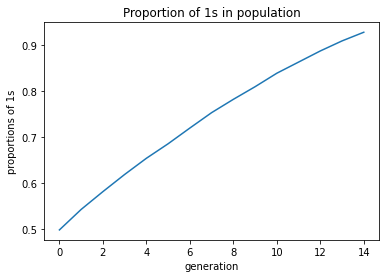

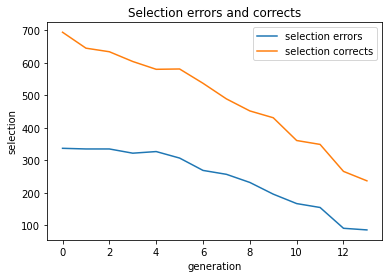

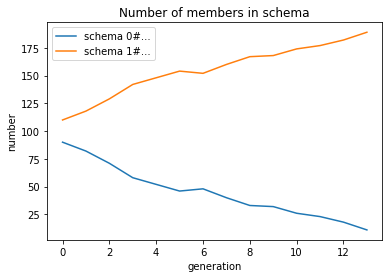

In [22]:
pop_size = 200
converged_genes,n_generations, proportion, errors, corrects,schema_0,schema_1 = genetic_search_measures(pop_size)


assert(n_generations == len(proportion) - 1) # -1 because we have 0's generation
assert(n_generations == len(errors) ) 
assert(n_generations == len(corrects) )



plt.plot(proportion)
plt.ylabel('proportions of 1s')
plt.xlabel('generation')
plt.savefig("proportion.png")
plt.title("Proportion of 1s in population")
plt.show()

plt.plot(errors, label="selection errors")
plt.plot(corrects, label="selection corrects")
plt.legend()
plt.ylabel('selection')
plt.xlabel('generation')
plt.title("Selection errors and corrects")
plt.savefig("selection.png")
plt.show()



number_member_schema_0 = []
number_member_schema_1 = []
average_schema_0 = []
average_schema_1 = []
std_schema_0 = []
std_schema_1 = []

for i in range(n_generations):
    assert(pop_size == len(schema_0[i]) + len(schema_1[i]) )
    number_member_schema_0.append(len(schema_0[i]))
    number_member_schema_1.append(len(schema_1[i]))
    std_schema_0.append(np.std(schema_0[i]))
    std_schema_1.append(np.std(schema_1[i]))
    average_schema_0.append(np.mean(schema_0[i]))
    average_schema_1.append(np.mean(schema_1[i]))

plt.plot(number_member_schema_0, label="schema 0#...")
plt.plot(number_member_schema_1, label="schema 1#...")
plt.ylabel('number')
plt.legend()

plt.xlabel('generation')
plt.title("Number of members in schema")
plt.savefig("members.png")
plt.show()



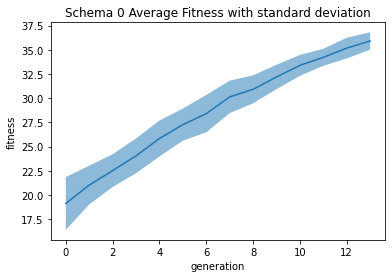

In [23]:
fig, ax = plt.subplots()
ax.fill_between(range(len(average_schema_0)), np.array(average_schema_0) + np.array(std_schema_0), np.array(average_schema_0) - np.array(std_schema_0), alpha=.5, linewidth=0)
plt.plot(average_schema_0)
plt.ylabel('fitness')

plt.xlabel('generation')
ax.set_title("Schema 0 Average Fitness with standard deviation")   
plt.savefig("schema0.png")
plt.show()


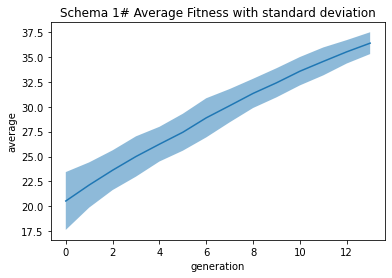

In [24]:
fig, ax = plt.subplots()
ax.fill_between(range(len(average_schema_1)), np.array(average_schema_1) + np.array(std_schema_1), np.array(average_schema_1) - np.array(std_schema_1), alpha=.5, linewidth=0)
plt.plot(average_schema_1)
plt.ylabel('average')

plt.xlabel('generation')
ax.set_title("Schema 1# Average Fitness with standard deviation")   
plt.savefig("schema1.png")
plt.show()


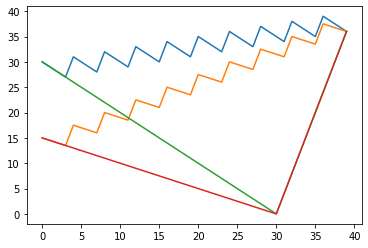

In [ ]:
plot_pop = []
for i in range(40):
    plot_pop.append("1"*i+"0"*(40-i))

plt.plot([tightlyLinkedTrapFunction(x,DECEPTIVE) for x in plot_pop])
plt.plot([tightlyLinkedTrapFunction(x,NON_DECEPTIVE) for x in plot_pop])
plt.plot([looslyLinkedTrapFunction(x,DECEPTIVE) for x in plot_pop])
plt.plot([looslyLinkedTrapFunction(x,NON_DECEPTIVE) for x in plot_pop])